In [1]:
from importlib import reload
from pprint import pprint

import pandas as pd
import numpy as np
# import matplotlib pyplot commands
from matplotlib.pyplot import *
from IPython.display import Image, Markdown
from qgrid import show_grid as sh
 
# Show Plots in the Notebook
%matplotlib inline
 
# 'style' the plot like fivethirtyeight.com website
style.use('bmh')

In [2]:
rcParams['figure.figsize']= (10, 6)   # set Chart Size
rcParams['font.size'] = 14            # set Font size in Chart

In [3]:
import heatpump.library as lib
reload(lib)

<module 'heatpump.library' from '/home/tabb99/heat-pump-calc/heatpump/library.py'>

In [4]:
import heatpump.hp_model
reload(heatpump.hp_model)
import heatpump.home_heat_model
reload(heatpump.home_heat_model)

<module 'heatpump.home_heat_model' from '/home/tabb99/heat-pump-calc/heatpump/home_heat_model.py'>

In [8]:
# Ambler
utility = lib.util_from_id(202)
inputs1 = dict(
    city_id=45,
    utility=utility,
    pce_limit=500,
    co2_lbs_per_kwh=1.6,
    exist_heat_fuel_id=4,
    exist_unit_fuel_cost=8.0,
    exist_fuel_use=None,
    exist_heat_effic=.86,
    exist_kwh_per_mmbtu=8,
    includes_dhw=False,
    occupant_count=3,
    includes_dryer=False,
    includes_cooking=False,
    elec_use_jan=500,
    elec_use_may=350,
    hp_model_id=601,
    low_temp_cutoff=5,
    off_months_chks=[12, 1],
    garage_stall_count=0,
    garage_heated_by_hp=False,
    bldg_floor_area=1000,
    indoor_heat_setpoint=70,
    insul_level=2,
    pct_exposed_to_hp=0.5,
    doors_open_to_adjacent=True,
    bedroom_temp_tolerance='med',
    capital_cost=6000,
    rebate_dol=0,
    pct_financed=0.0,
    loan_term=10,
    loan_interest=0.05,
    hp_life=14,
    op_cost_chg=0,
    sales_tax=0.00,
    discount_rate=0.05,
    inflation_rate=0.02,
    fuel_esc_rate=0.03,
    elec_esc_rate=0.02,
)

In [9]:
# Function to return model object and hourly results from running model with 
# inputs1, but allowing for easy adjustment of any of those
# inputs.
def run_mod(updated_inputs={}):
    # 'updated_inputs' is a dictionary with new values for any
    # of the inputs.
    inps = inputs1.copy()
    inps.update(updated_inputs)
    mod = heatpump.hp_model.HP_model(**inps)
    mod.run()
    return mod, mod.df_hourly.copy()

In [10]:
m, dfh = run_mod()
m.summary

{'fuel_unit': 'gallon',
 'fuel_desc': '#1 Oil',
 'design_heat_load': 22661.100000000002,
 'design_heat_temp': -49.900000000000006,
 'cop': 2.730690295305998,
 'hp_max_capacity_5F': 13309.359,
 'max_hp_reached': False,
 'co2_lbs_saved': 694.3769118708769,
 'co2_driving_miles_saved': 778.5637934168324,
 'hp_load_frac': 0.5375309089063168,
 'irr': 0.1280532219596242,
 'npv': 3790.1075822286884,
 'fuel_use_base': 462.16700778348866,
 'fuel_use_hp': 216.8349194549039,
 'fuel_use_chg': -245.33208832858475,
 'fuel_price_incremental': 8.0,
 'elec_use_base': 4661.587156420448,
 'elec_use_hp': 7627.1388332867255,
 'elec_use_chg': 2965.5516768662774,
 'elec_rate_avg_base': 0.2436711703899061,
 'elec_rate_avg_hp': 0.30661659955107456,
 'elec_rate_incremental': 0.4055612938627722}

In [11]:
dfh.iloc[0]

db_temp                    -24.16
day_of_year                     1
month                           1
running                     False
cop                      0.733657
hp_load_mmbtu                   0
secondary_load_mmbtu    0.0154836
hp_kwh                          0
secondary_fuel_mmbtu    0.0180042
secondary_kwh            0.123869
total_kwh                0.123869
Name: 2018-01-01 00:30:00, dtype: object

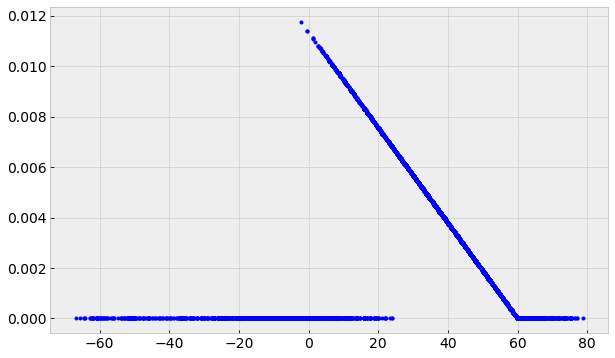

In [60]:
# Heat Pump Load vs. Outdoor Temperature
# Overlap due to 1-day analysis of Low Temperature Cutoff
plot(dfh.db_temp, dfh.hp_load_mmbtu, 'b.')

In [61]:
# Balance Point
dfh.query('hp_load_mmbtu == 0.0 and db_temp > 40')['db_temp'].min()
# Very close to 60, which was the assumed balance point with Level 2
# insulation and no UA Adjustment.

60.08

In [62]:
# Try a better insulated house
m, dfh = run_mod({'insul_level': 3})
dfh.query('hp_load_mmbtu == 0.0 and db_temp > 40')['db_temp'].min()
# Yes, the balance point temperature went down.

56.84

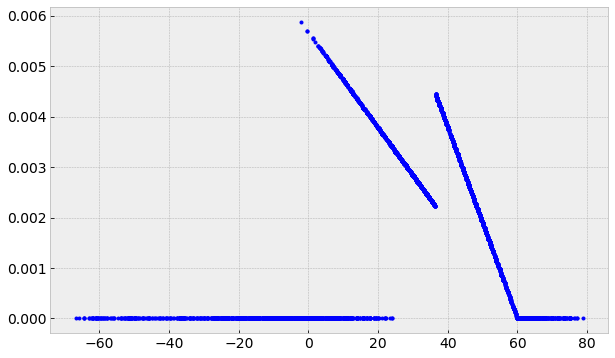

In [63]:
# Try closing doors to see if there is a breakpoint in the load
m, dfh = run_mod( dict(doors_open_to_adjacent=False) )
plot(dfh.db_temp, dfh.hp_load_mmbtu, 'b.')
# Yes!

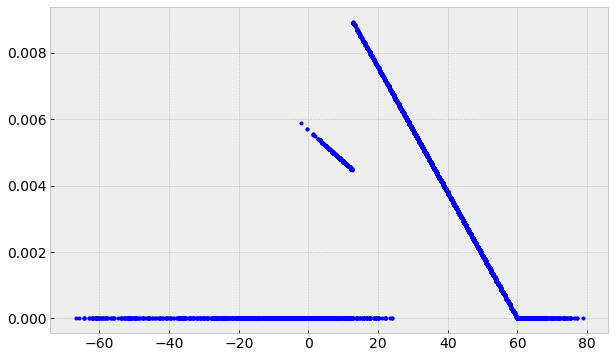

In [64]:
# Allow bedroom temperature to dip more
# Try closing doors to see if there is a breakpoint in the load
m, dfh = run_mod( dict(doors_open_to_adjacent=False,
                       bedroom_temp_tolerance='high') 
                )
plot(dfh.db_temp, dfh.hp_load_mmbtu, 'b.')
# Breakpoint moves lower

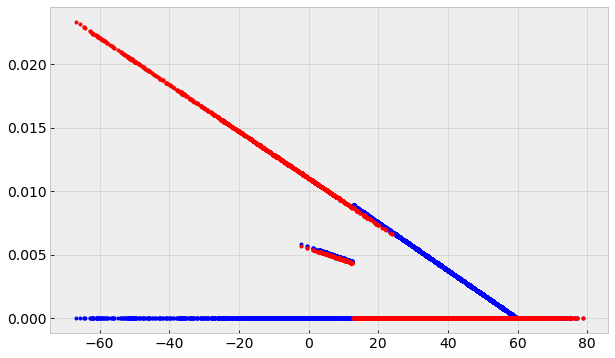

In [65]:
# Same scenario but look at secondary load as well
m, dfh = run_mod( dict(doors_open_to_adjacent=False,
                       bedroom_temp_tolerance='high') 
                )
plot(dfh.db_temp, dfh.hp_load_mmbtu, 'b.')
plot(dfh.db_temp, dfh.secondary_load_mmbtu, 'r.')
# In the overlap areas, some days the secondary system is serving
# the load, and other days, the heat pump is.  So they should be 
# close to the same.  Secondary load is a bit less due to auxiliary
# electricity use serving part of load.  Verify that in next graph

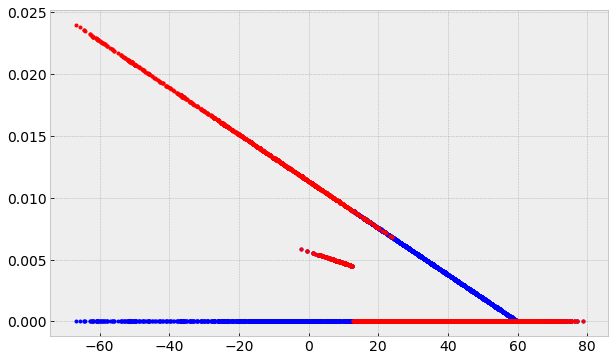

In [66]:
# Verify that loads are same when aux use is 0
m, dfh = run_mod( dict(doors_open_to_adjacent=False,
                       bedroom_temp_tolerance='high',
                       exist_kwh_per_mmbtu=0.0) 
                )
plot(dfh.db_temp, dfh.hp_load_mmbtu, 'b.')
plot(dfh.db_temp, dfh.secondary_load_mmbtu, 'r.')
# Yes

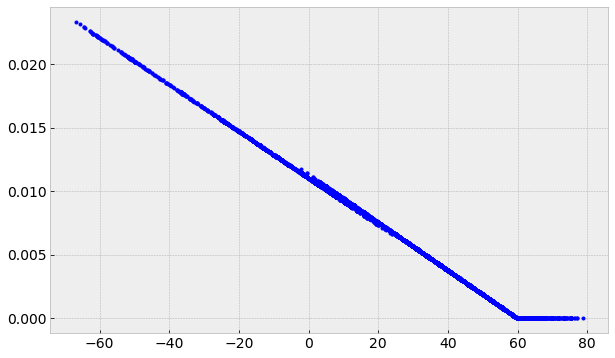

In [67]:
# Back to base case
m, dfh = run_mod()
# plot the total load
dfh['total_load'] = dfh.hp_load_mmbtu + dfh.secondary_load_mmbtu
plot(dfh.db_temp, dfh.total_load, 'b.')
# Some scatter cuz of the aux elec use issue.

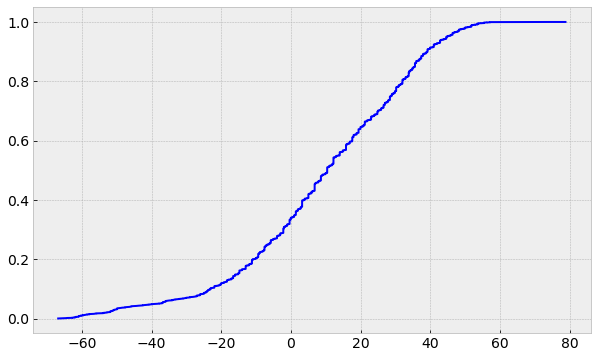

In [72]:
# Look at cumulative load, sorted from coldest to warmest.
df_sort = dfh.sort_values('db_temp')
cum_load = df_sort['total_load'].cumsum()
cum_load /= cum_load.iloc[-1]   # Scaled to 1.0 total load
plot(df_sort.db_temp, cum_load, 'b-')

In [75]:
# Make sure electric cost calculation is working OK
m.utility, m.sales_tax

(ID                                                            202
 Name                                    AVEC-Ambler - Residential
 Active                                                       True
 Type                                                            1
 IsCommercial                                                False
 ChargesRCC                                                  False
 PCE                                                        0.2943
 CO2                                                           1.8
 CustomerChg                                                     5
 DemandCharge                                                  NaN
 NameShort                                                  AVEC-A
 Blocks          [(700.0, 0.525100007653236), (nan, 0.425099998...
 Name: 202, dtype: object, 0.0)

In [73]:
m.df_mo_dol_hp

,elec_kwh,elec_kw,elec_dol,secondary_fuel_units,secondary_fuel_dol,total_dol
Jan,649.200672,3.393783,198.745283,69.081868,552.654942,751.400225
Feb,686.201720,3.080687,218.174533,38.718564,309.748509,527.923042
Mar,866.224254,3.009243,296.081940,15.183053,121.464423,417.546363
Apr,700.431127,2.733251,225.603283,14.970980,119.767840,345.371122
May,591.370378,2.792300,168.378595,0.000000,0.000000,168.378595
Jun,376.013325,1.562893,91.783882,0.000000,0.000000,91.783882
Jul,394.055658,1.593881,95.948053,0.000000,0.000000,95.948053
Aug,459.015895,2.014730,110.940877,0.000000,0.000000,110.940877
Sep,628.947590,2.188453,188.110389,0.000000,0.000000,188.110389
Oct,791.326222,2.709781,264.242787,0.000000,0.000000,264.242787


In [76]:
# Calculate March Electic Cost
print(
    5 + 500 * (0.5251 - .2943) + 200 * 0.5251 + (866.22 - 700) * .4251
)
# Checks

296.080122


In [77]:
# Calculate June Electric Cost
print(
    5 + 376.01 * (.5251 - .2943)
)
# Checks

91.783108


In [83]:
# Number of days that heat pump runs by Month
m, dfh = run_mod(dict(low_temp_cutoff=0))
dfh.groupby('month')['running'].sum()/24.0

month
1     11.0
2     14.0
3     26.0
4     26.0
5     31.0
6     30.0
7     31.0
8     31.0
9     30.0
10    31.0
11    15.0
12    22.0
Name: running, dtype: float64

In [86]:
lib.fuel_from_id(1)

desc                              Electricity
unit                                      kWh
btus                                     3413
co2                                       NaN
price_col                                 NaN
dhw_effic                                0.93
effic_choices    [(Electric Resistance, 100)]
Name: 1, dtype: object

In [88]:
# The days in each month
DAYS_IN_MONTH = np.array([
    31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31
])

# The pattern or Lights and appliances other than DHW, Clothes Drying & Cooking.
# This is average power in the month divided average annual power.
LIGHTS_OTHER_PAT = np.array([
    1.13, 1.075, 1.0, 0.925, 0.87, 0.85, 0.87, 0.925, 1.0, 1.075, 1.13, 1.15
])
sum(DAYS_IN_MONTH * LIGHTS_OTHER_PAT)/365.

0.9996438356164382

### Work on Stopping Use in Certain Months

In [26]:
dfh.head()

,db_temp,day_of_year,month,running,cop,hp_load_mmbtu,secondary_load_mmbtu,hp_kwh,secondary_fuel_mmbtu,secondary_kwh,total_kwh
timestamp,,,,,,,,,,,
2018-01-01 00:30:00,-24.16,1,1,False,0.733657,0.0,0.015484,0.0,0.018004,0.123869,0.123869
2018-01-01 01:30:00,-24.16,1,1,False,0.733657,0.0,0.015484,0.0,0.018004,0.123869,0.123869
2018-01-01 02:30:00,-24.34,1,1,False,0.733657,0.0,0.015517,0.0,0.018043,0.124134,0.124134
2018-01-01 03:30:00,-24.88,1,1,False,0.733657,0.0,0.015616,0.0,0.018158,0.124929,0.124929
2018-01-01 04:30:00,-24.34,1,1,False,0.733657,0.0,0.015517,0.0,0.018043,0.124134,0.124134


In [17]:
dfh.running.value_counts()

True     6720
False    2040
Name: running, dtype: int64

In [21]:
mask = dfh.month.isin([12, 1])
dfh.loc[mask, 'running'] = False

In [22]:
dfh.loc[mask].running.value_counts()

False    1488
Name: running, dtype: int64